# CP2K input generation and calculations

In this tutorial, we will demonstrate how to generate input files for various types of CP2K calculations using one of Libra's modueles. As an example, we'll consider a formaldehyde molecule - mainly for speed and smallness of the output.

*Importantly*: in practice, the calculations would be much more convenient using normal Python files, not the Jupyter notebooks, but we use the notebook for demonstration

## Table of Content <a name="TOC"></a>

1. [General setups](#1)

2. [CP2K calculations](#2) 

   2.1. [Ground-state calculations](#2.1) 
   
      - 2.1.1. [OT xTB, single point, single particle](#2.1.1)
      
      - 2.1.2. [DIAG + added MO xTB, single point, single particle](#2.1.2)
      
      - 2.1.3. [DIAG + added MO xTB, single point, single particle, with smearing](#2.1.3)
      
      - 2.1.4. [DIAG + added MO PBE, single point, single particle](#2.1.4)
      
      - 2.1.5. [OT PBE, single point, single particle](#2.1.5)
      
      - 2.1.6a. [Hybrid functionals: B3LYP + OT](#2.1.6a)
      
      - 2.1.6b. [Hybrid functionals: HSE06 + OT](#2.1.6b)
      
      - 2.1.6c. [Hybrid functionals: PBE0 + OT](#2.1.6c)
      
      - 2.1.6d. [Hybrid functionals: CAM-B3LYP + OT](#2.1.6d)
   
   2.2. [Excited-state calculations](#2.2) 
   
      - 2.2.1. [xTB + sTDA](#2.2.1)
      
      - 2.2.2. [PBE + TD-DFT](#2.2.2)
      
      - 2.2.3. [PBE + TD-DFT (sTDA)](#2.2.3)
      
      - 2.2.4a. [PBE0 + TD-DFT (full)](#2.2.4a)
      
      - 2.2.4b. [B3LYP + TD-DFT (full)](#2.2.4b)
      
      - 2.2.4c. [CAM-B3LYP + TD-DFT (full)](#2.2.4c)
   
3. [Summary](#3)

### A. Learning objectives

- to setup ground state calculations with CP2K at the xTB, DFT level 
- to setup excited state calculations with CP2K at the sTDA and TD-DFT levels 


### B. Use cases

- to setup xTB calculations with CP2K
- to setup DFT (pure functional) state calculations with CP2K
- to setup DFT (hybrid functional) state calculations with CP2K
- to use OT approach for SCF convergence
- to use diagonalization-based approach for SCF convergence
- to use smearing in CP2K calculations
- to add extra MOs
- to use simplified Tamm-Dancoff approximation (sTDA) for excited state calculations
- to use the full kernel in TD-DFT calculations


### C. Functions

- `libra_py`  
  - `packages`
    - `cp2k`
      - `input`
        - [`generate`](#generate-1)


### D. Classes and class members

None

## 1. General setups
<a name="1"></a> [Back to TOC](#TOC)

In [1]:
import os, sys
import libra_py
import libra_py.packages.cp2k.input as cp2k_input

/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vect

## 2. CP2K calculations
<a name="2"></a> [Back to TOC](#TOC)

First, let's check the documentation for the `generate` function.

In [2]:
help(cp2k_input.generate)

Help on function generate in module libra_py.packages.cp2k.input:

generate(_params)
    Args: 
        _params ( dict ): dictionary of the parameters controlling the calculations
    
        * **_params["input_filename"]** ( string ) : the name of the input file generated [ default: "md.inp"]
        * **_params["project"]** (string): the project name to be defined in the input file, this variable will
            be used to define the output filenames [ defaults: "Ti17" - this is just for historical reasons]
        * **_params["run_type"]** (string): the run type to be done, see the CP2K manual for the possible options.
            Here, we mainly will use "ENERGY" (for single-point calculations; default) or "MD" (for molecular dynamics)
        * **_params["print_level"]** (string): how much of output to produce by CP2K; see the CP2K manual for the possible options
            [default: "LOW"]. Possible: "MEDIUM", "HIGH"
        * **_params["charge"]** (int): the charge of the sys

As you can tell, many important parameters are already set to reasonable default values, so on the user's side one just needs to define the rest of the parameters. 

Here, we'll define some common non-default parameters first and then will use the customizations for other kinds of calculations

First, let's define some kinds of atom species:

In [3]:
h = {"element": "H", "basis_set":"ORB DZVP-GTH", "potential":"GTH-PBE-q1", "fit_basis_set":"cFIT3" }
c = {"element": "C", "basis_set":"ORB DZVP-GTH", "potential":"GTH-PBE-q4", "fit_basis_set":"cFIT3" }
o = {"element": "O", "basis_set":"ORB DZVP-GTH", "potential":"GTH-PBE-q6", "fit_basis_set":"cFIT3" }
ti = {"element": "Ti", "basis_set":"ORB DZVP-MOLOPT-SR-GTH", "potential":"GTH-PBE-q12", "fit_basis_set":"cFIT10" }
ti_u = {"element": "Ti", "basis_set":"ORB DZVP-MOLOPT-SR-GTH", "potential":"GTH-PBE-q12", "fit_basis_set":"cFIT10",
        "dft_plus_u":[2, 0.1] }

In this tutorial, we aren't doing the DFT+U calculations, but I show two types of "ti" kinds - one without additional DFT+U calculations ("ti") and the other one - with the U correction of 0.1 Ha added to the d orbital of Ti ("ti_u")

So, let's setup out default parameters:

In [4]:
default_params = { "input_filename":"md.inp",
                   "project":"ch2o", "run_type":"ENERGY", "print_level":"LOW",

                    "charge":0, "multiplicity":1, "uks":".FALSE.",

                    "method":"PBE", "max_scf":100,
                    "solver":"DIAG",
                    "ot.preconditioner":"FULL_SINGLE_INVERSE", "ot.minimizer":"DIIS", 
                    "ot.linesearch":"2PNT", "ot.energygap":0.01,
                    "diag.preconditioner":"FULL_SINGLE_INVERSE", "diag.energygap":0.01,
                    "added_mos":20, "smearing":False,
                    "smearing.method":"FERMI_DIRAC", "smearing.electronic_temperature":300.0,

                    "istate":0, "nstates":2, "tddft_kernel":"FULL",

                    "cell.A":[30.0, 0.0, 0.0], 
                    "cell.B":[0.0, 30.0, 0.0], 
                    "cell.C":[0.0, 0.0, 30.0], 
                    "cell.periodic":"XYZ",
                    "xyz_file":"ch2o.xyz",

                    "kinds": [  h, c, o  ]
                }

Next, we are going to consider special cases. The CP2K calculations with the corresponding input files are conducted on the CCR, using the included `submit.slm` file. The generated files are placed in the corresponding folders - separately for each case:

### 2.1. Ground-state calculations
<a name="2.1"></a> [Back to TOC](#TOC)

#### 2.1.1  OT xTB, single point, single particle
<a name="2.1.1"></a> [Back to TOC](#TOC)

In [5]:
if(not os.path.exists("2_1_1") ):
    os.system("mkdir 2_1_1")
os.chdir("2_1_1")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"xTB", "solver":"OT"})
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 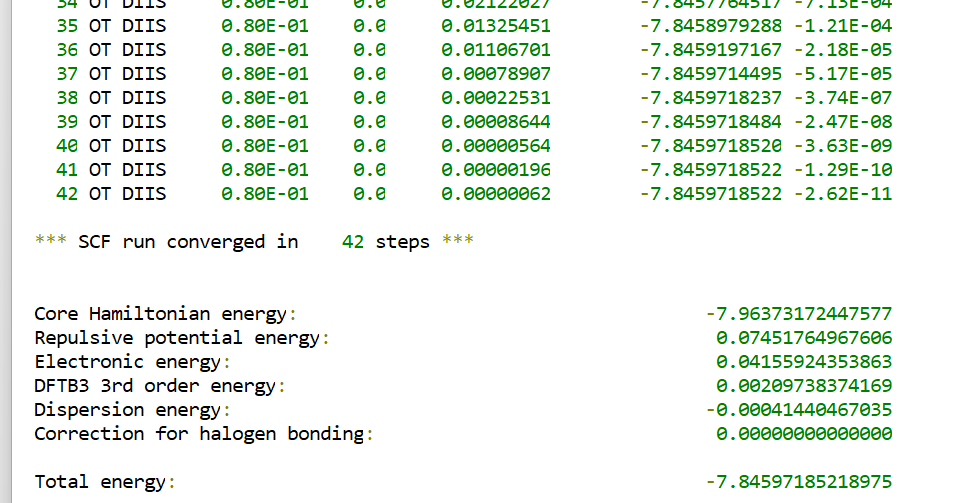 | 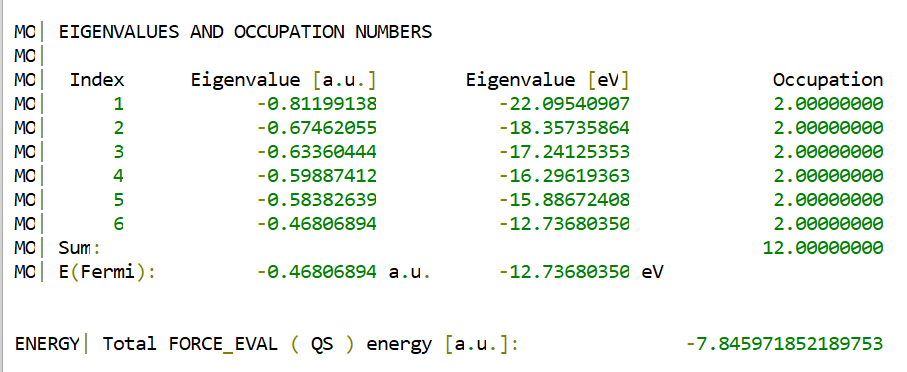 |

#### 2.1.2  DIAG + added MO xTB, single point, single particle
<a name="2.1.2"></a> [Back to TOC](#TOC)

In [6]:
if(not os.path.exists("2_1_2") ):
    os.system("mkdir 2_1_2")
os.chdir("2_1_2")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"xTB", "solver":"DIAG", "added_mos":10 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 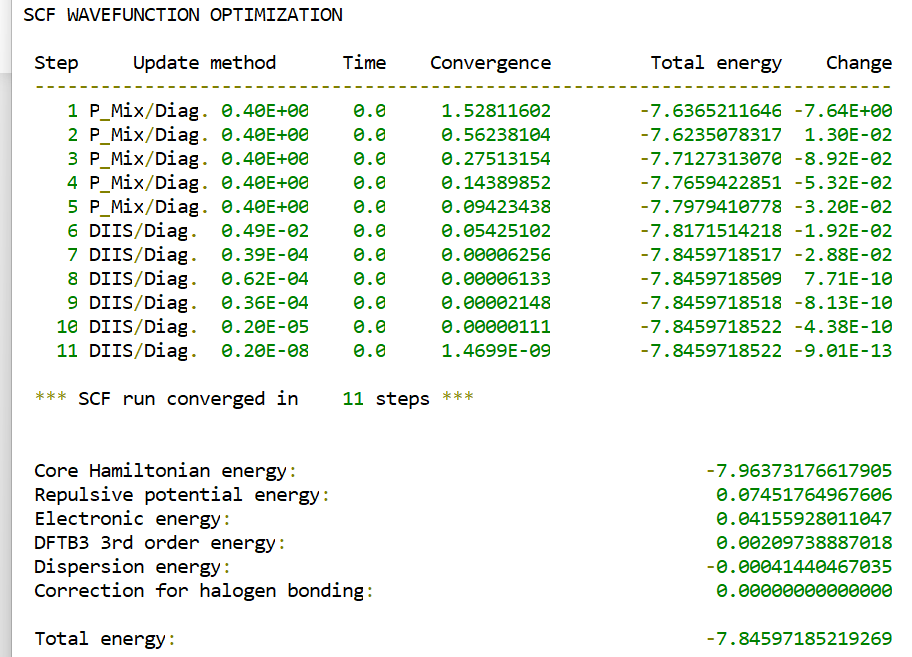 | 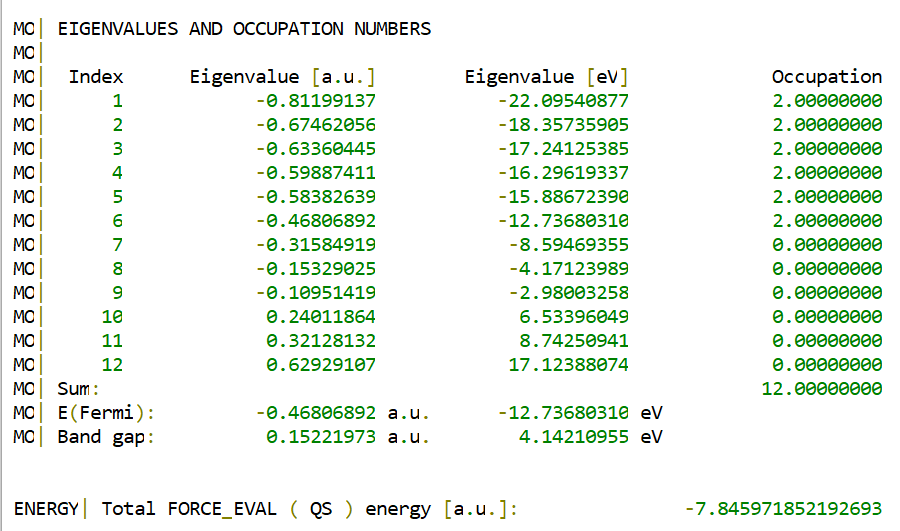 |

#### 2.1.3  DIAG + added MO xTB, single point, single particle, with smearing
<a name="2.1.3"></a> [Back to TOC](#TOC)

In [7]:
if(not os.path.exists("2_1_3") ):
    os.system("mkdir 2_1_3")
os.chdir("2_1_3")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"xTB", "solver":"DIAG", "added_mos":10, 
               "smearing":True, "smearing.electronic_temperature":3000.0})
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 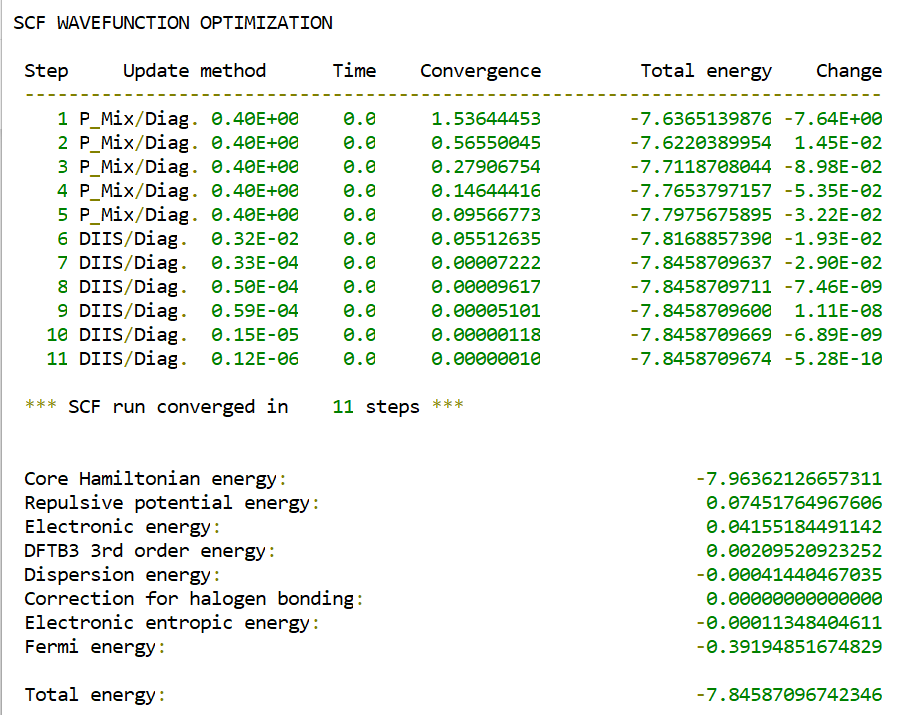 | 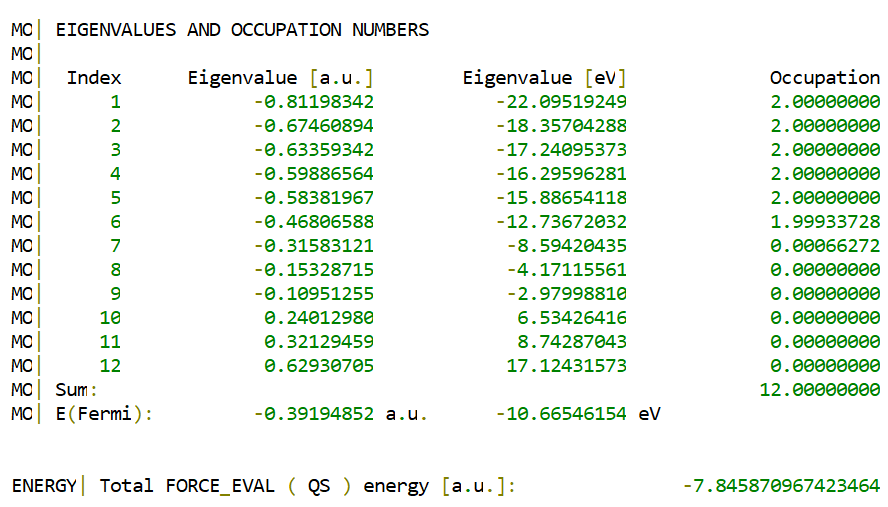 |

#### 2.1.4  DIAG + added MO PBE, single point, single particle
<a name="2.1.4"></a> [Back to TOC](#TOC)

In [8]:
if(not os.path.exists("2_1_4") ):
    os.system("mkdir 2_1_4")
os.chdir("2_1_4")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE", "solver":"DIAG", "added_mos":10 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 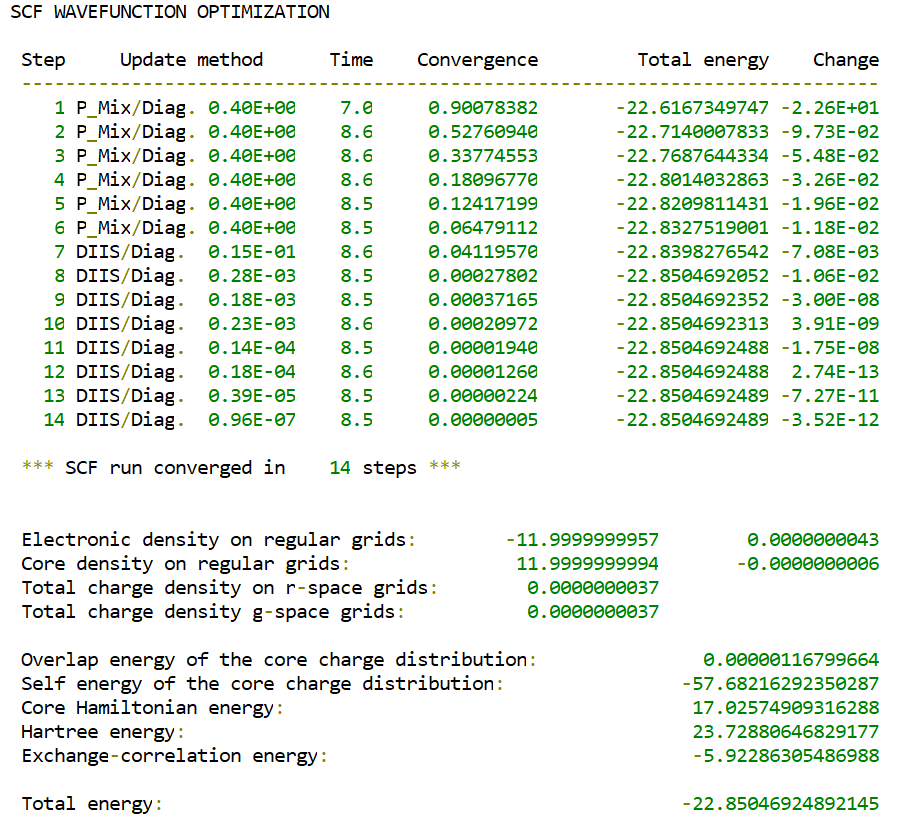 | 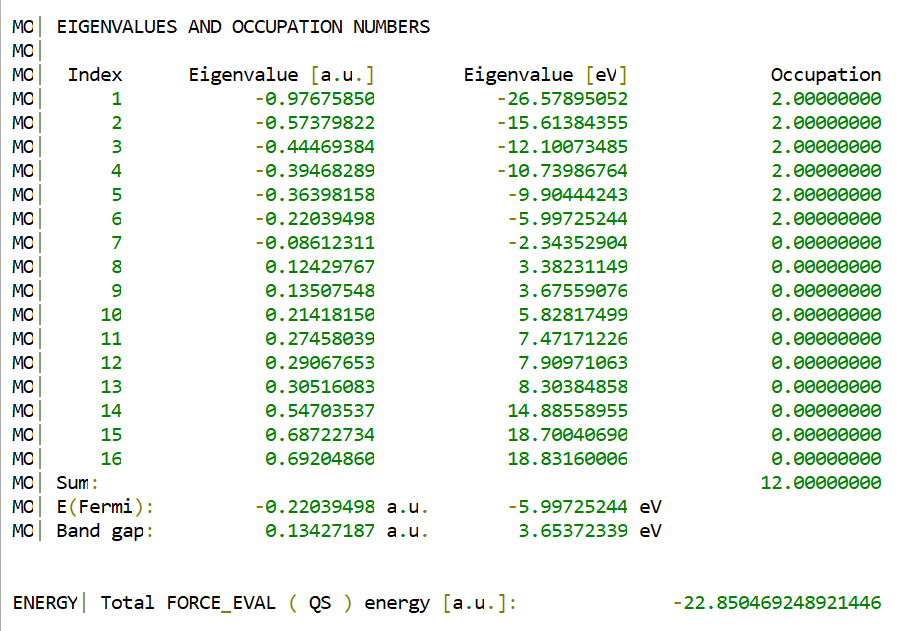 |

#### 2.1.5  OT PBE, single point, single particle
<a name="2.1.5"></a> [Back to TOC](#TOC)

The default setting lead to a poor convergence of this method, while the DIAG method works well in this case. So, we'll use the DIAG with the hybrids next

In [9]:
if(not os.path.exists("2_1_5") ):
    os.system("mkdir 2_1_5")
os.chdir("2_1_5")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE", "solver":"OT" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 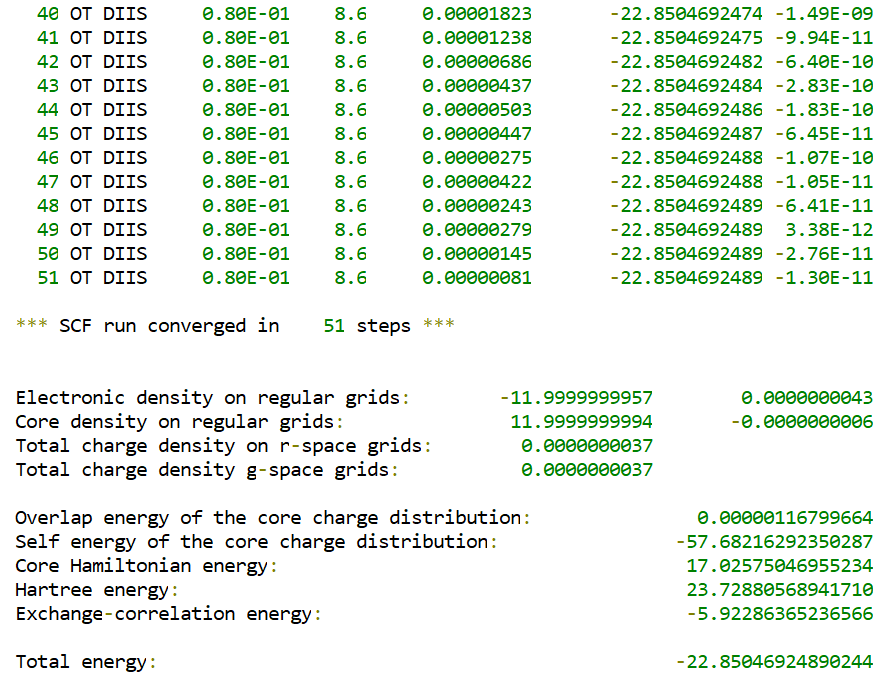 | 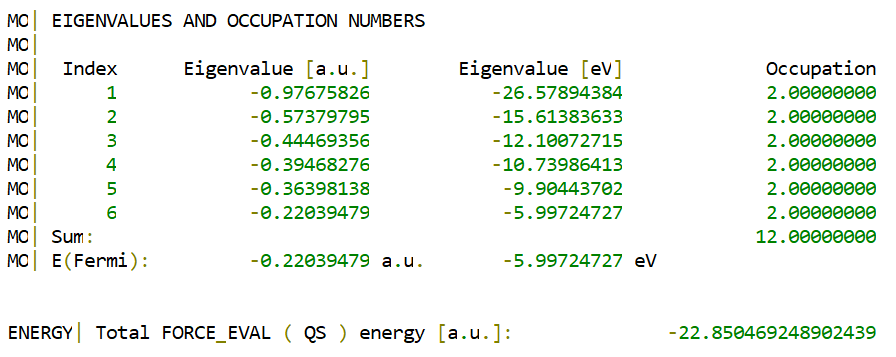 |

#### 2.1.6a  Hybrid functionals: B3LYP + OT
<a name="2.1.6a"></a> [Back to TOC](#TOC)

In [10]:
if(not os.path.exists("2_1_6a") ):
    os.system("mkdir 2_1_6a")
os.chdir("2_1_6a")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"B3LYP", "solver":"OT", "ot.preconditioner":"FULL_SINGLE_INVERSE" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 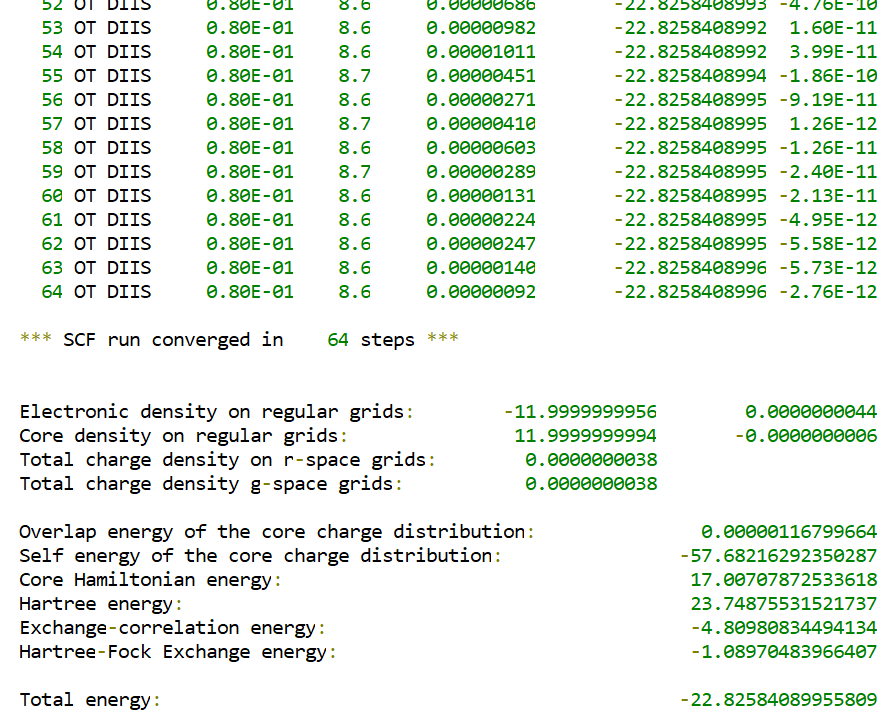 | 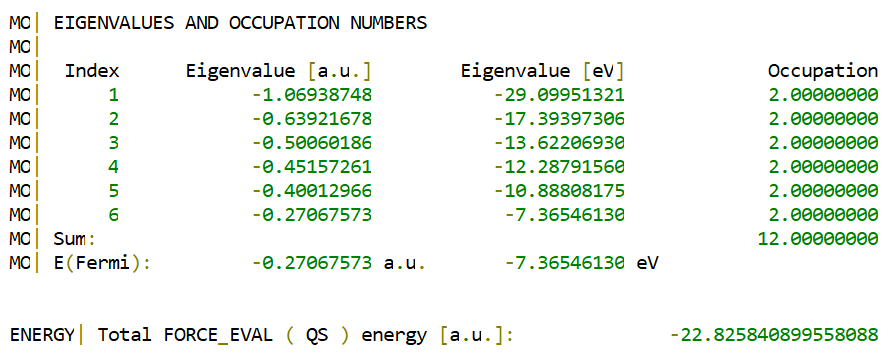 |

#### 2.1.6b  Hybrid functionals: HSE06 + OT
<a name="2.1.6b"></a> [Back to TOC](#TOC)

In [11]:
if(not os.path.exists("2_1_6b") ):
    os.system("mkdir 2_1_6b")
os.chdir("2_1_6b")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"HSE06", "solver":"OT", "ot.preconditioner":"FULL_SINGLE_INVERSE" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 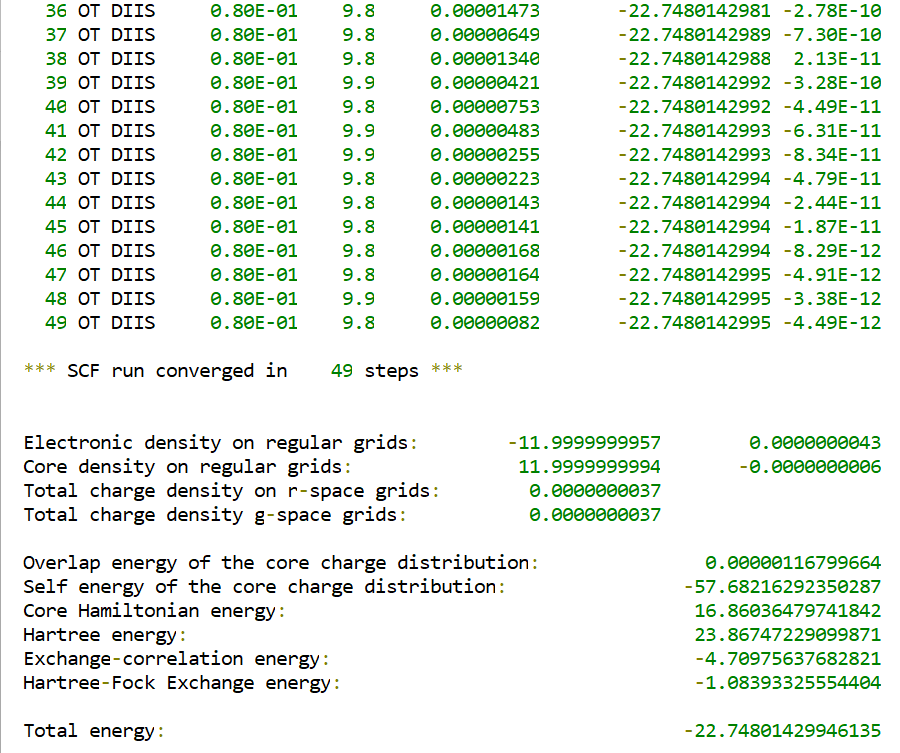 | 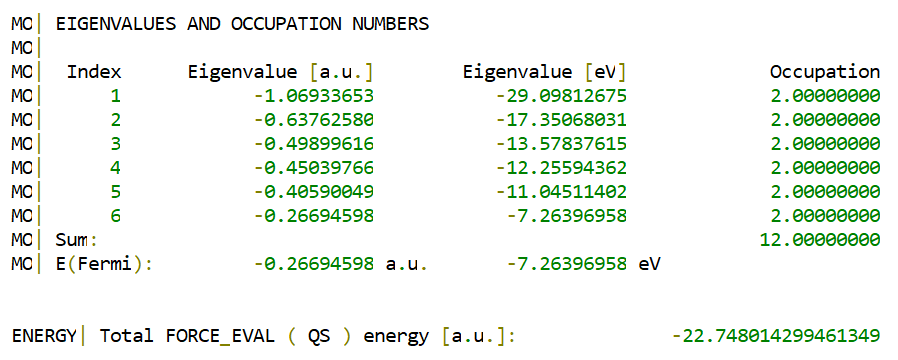 |

#### 2.1.6c  Hybrid functionals: PBE0 + OT
<a name="2.1.6c"></a> [Back to TOC](#TOC)

In [12]:
if(not os.path.exists("2_1_6c") ):
    os.system("mkdir 2_1_6c")
os.chdir("2_1_6c")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE0", "solver":"OT" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 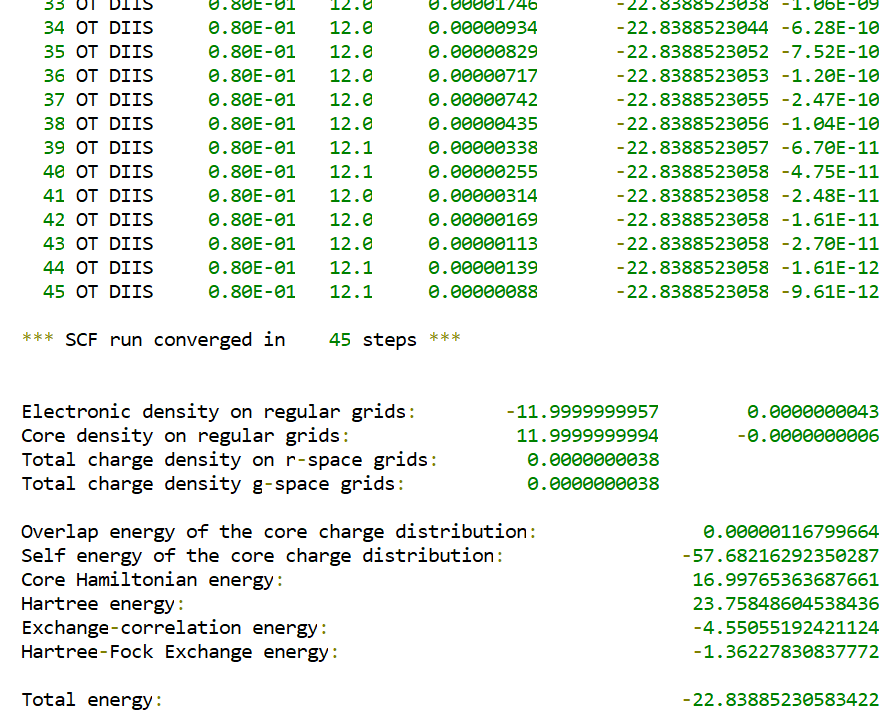 | 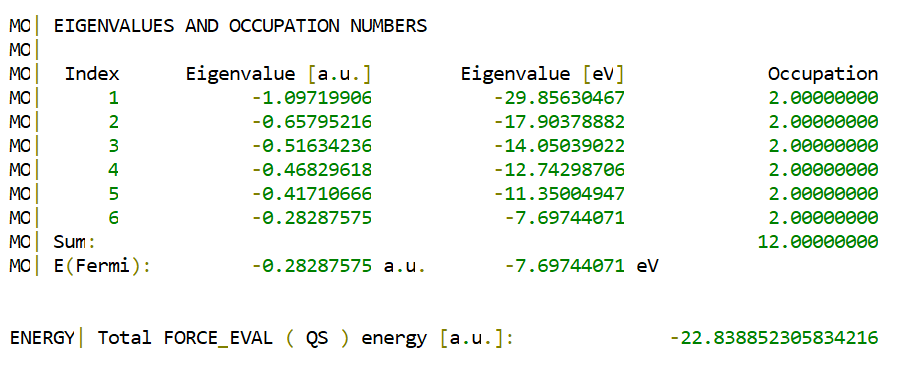 |

#### 2.1.6d  Hybrid functionals: CAM-B3LYP + OT
<a name="2.1.6d"></a> [Back to TOC](#TOC)

In [13]:
if(not os.path.exists("2_1_6d") ):
    os.system("mkdir 2_1_6d")
os.chdir("2_1_6d")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"CAM-B3LYP", "solver":"OT" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |
   | --- | --- |
   | 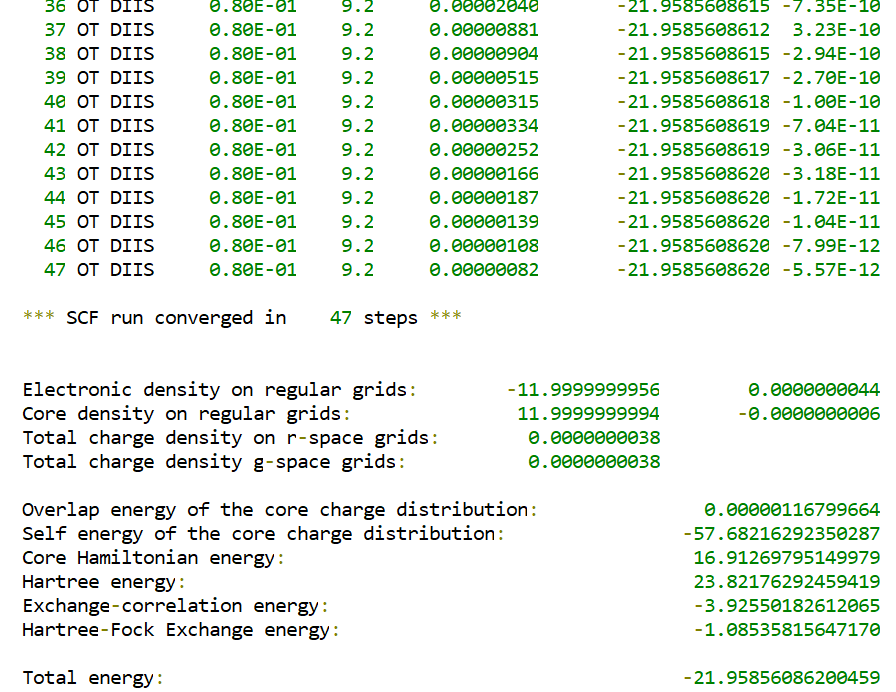 | 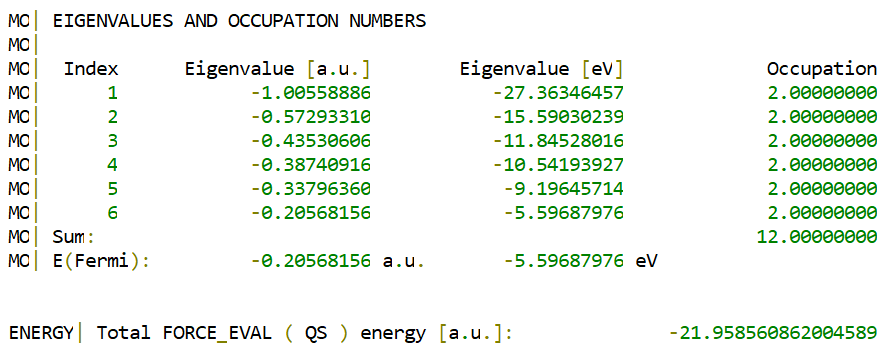 |

### 2.2. Excited-state calculations
<a name="2.2"></a> [Back to TOC](#TOC)

#### 2.2.1 xTB + sTDA 
<a name="2.2.1"></a> [Back to TOC](#TOC)

This goes with the sTDA TD-DFT kernel by default

In [14]:
if(not os.path.exists("2_2_1") ):
    os.system("mkdir 2_2_1")
os.chdir("2_2_1")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"xTB", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 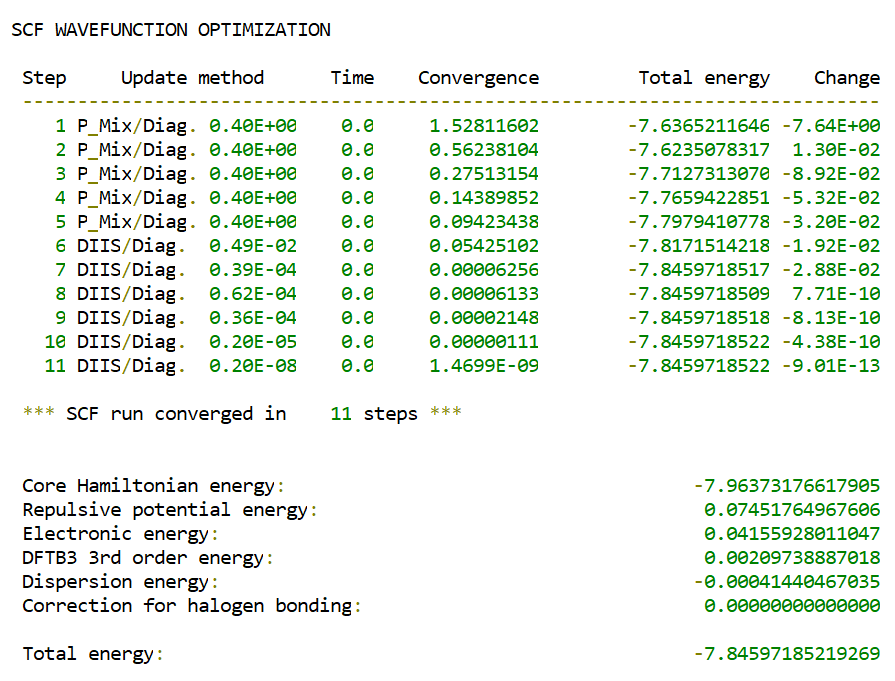 | 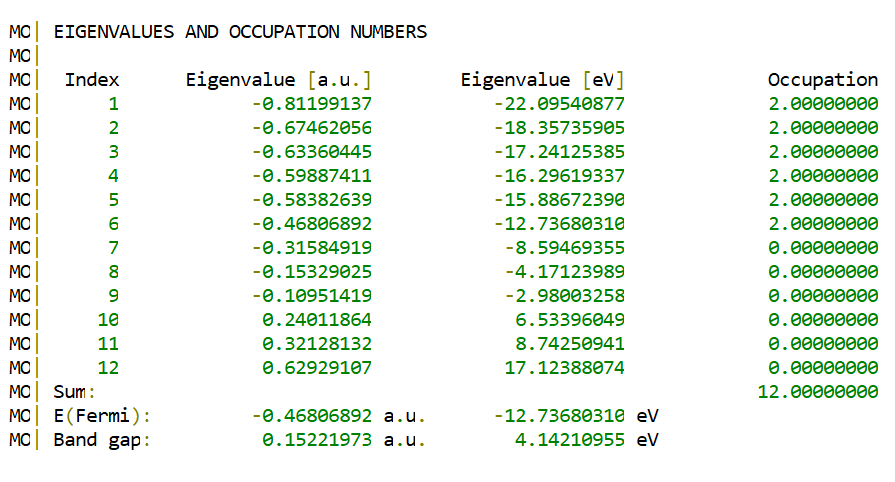 | 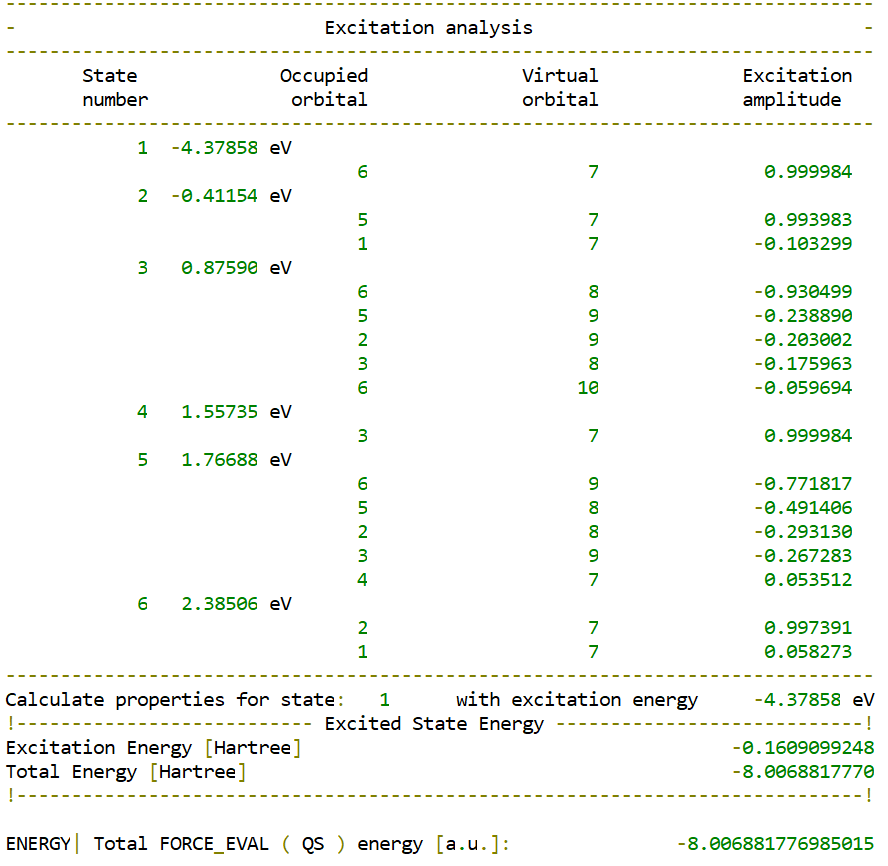 |

#### 2.2.2 PBE + TD-DFT
<a name="2.2.2"></a> [Back to TOC](#TOC)

This goes with the full TD-DFT kernel by default

In [15]:
if(not os.path.exists("2_2_2") ):
    os.system("mkdir 2_2_2")
os.chdir("2_2_2")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 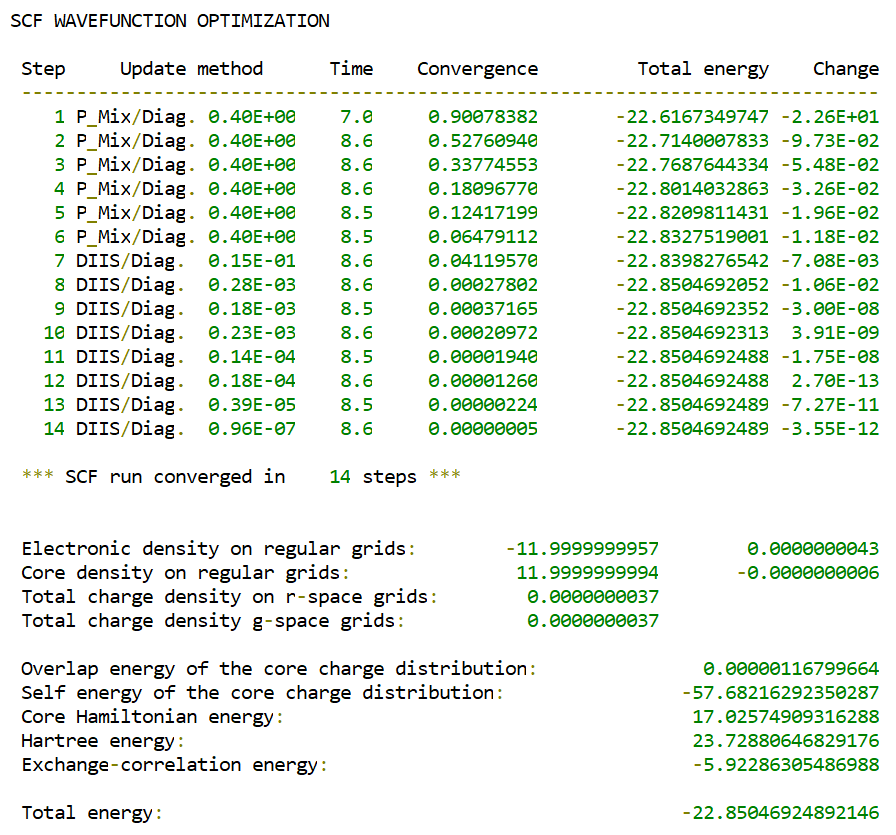 | 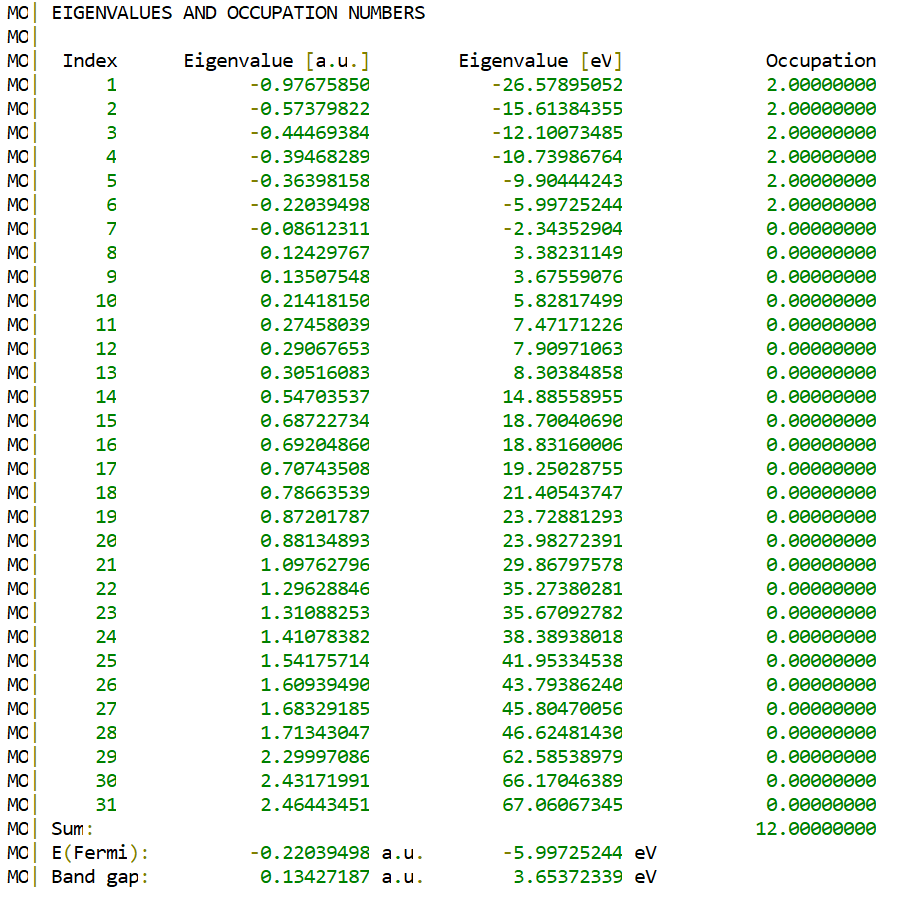 | 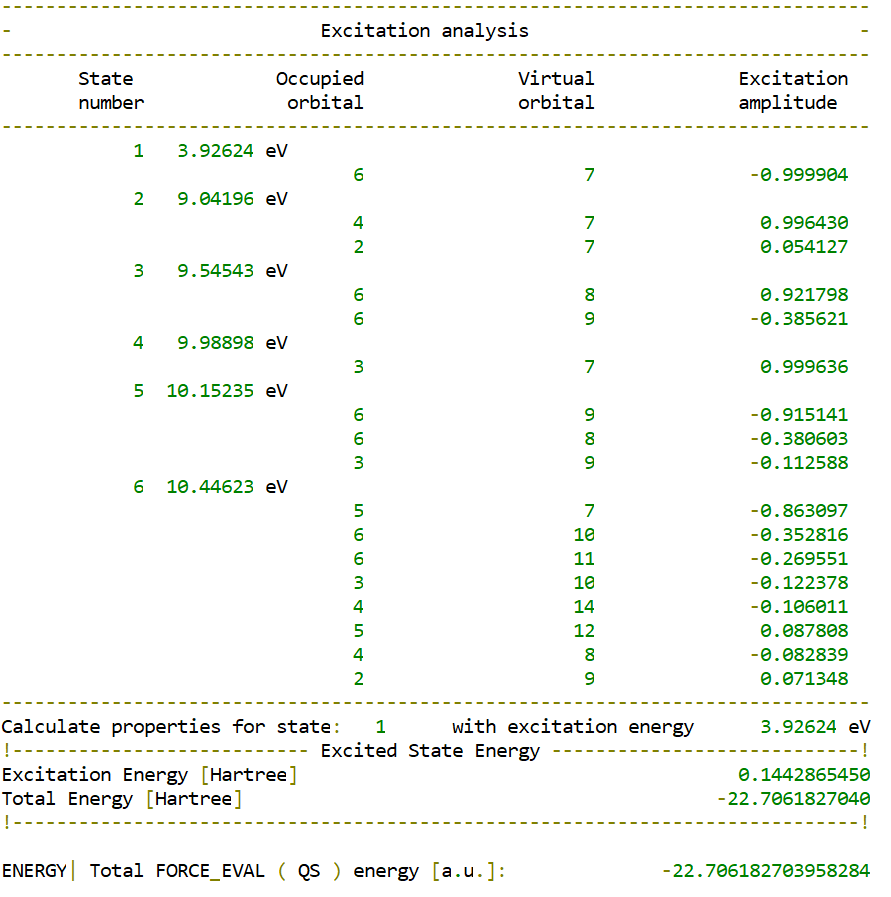 |

#### 2.2.3 PBE + TD-DFT (sTDA)
<a name="2.2.3"></a> [Back to TOC](#TOC)

Here is how we can use the sTDA kernel for excited states calculations with pure functionals

In [16]:
if(not os.path.exists("2_2_3") ):
    os.system("mkdir 2_2_3")
os.chdir("2_2_3")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25, "tddft_kernel":"STDA" })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 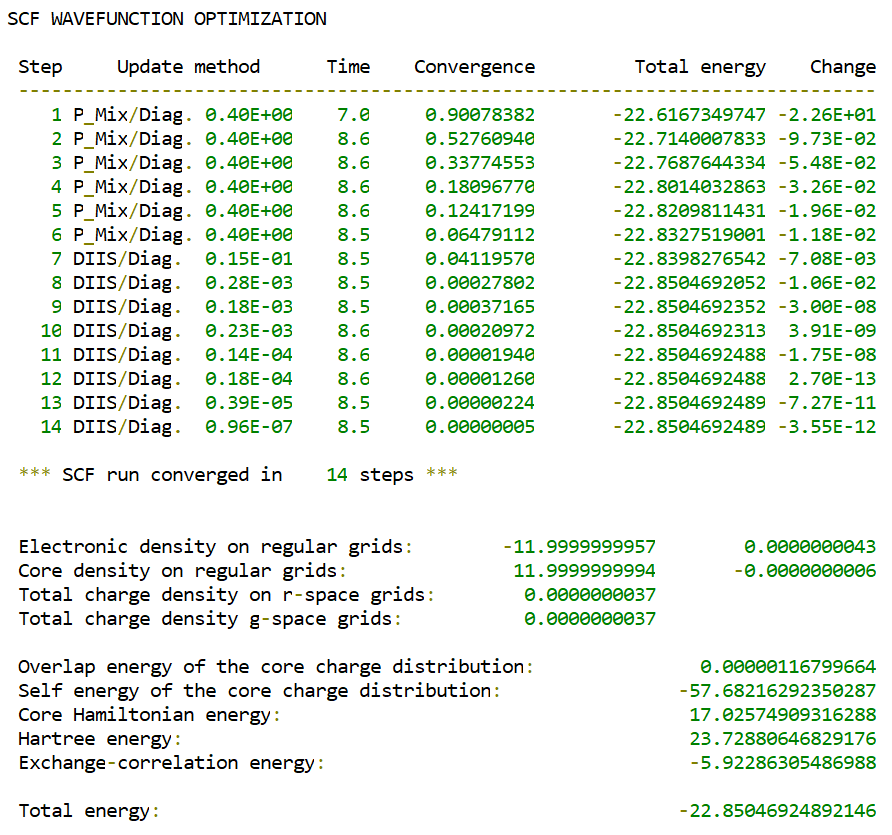 | 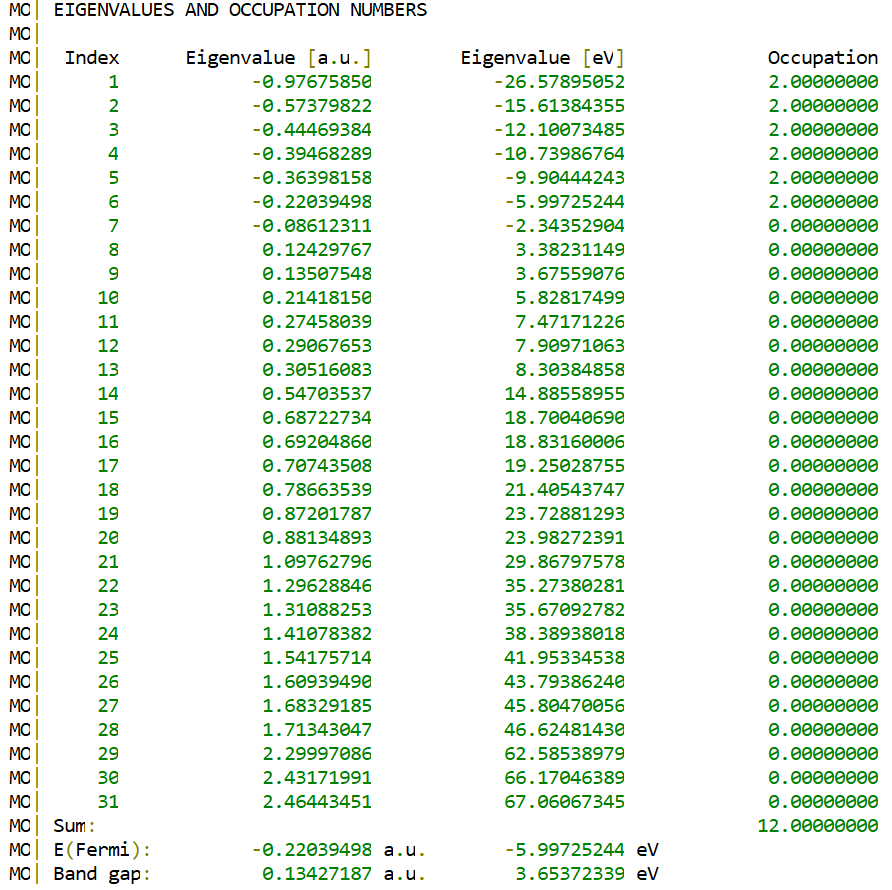 | 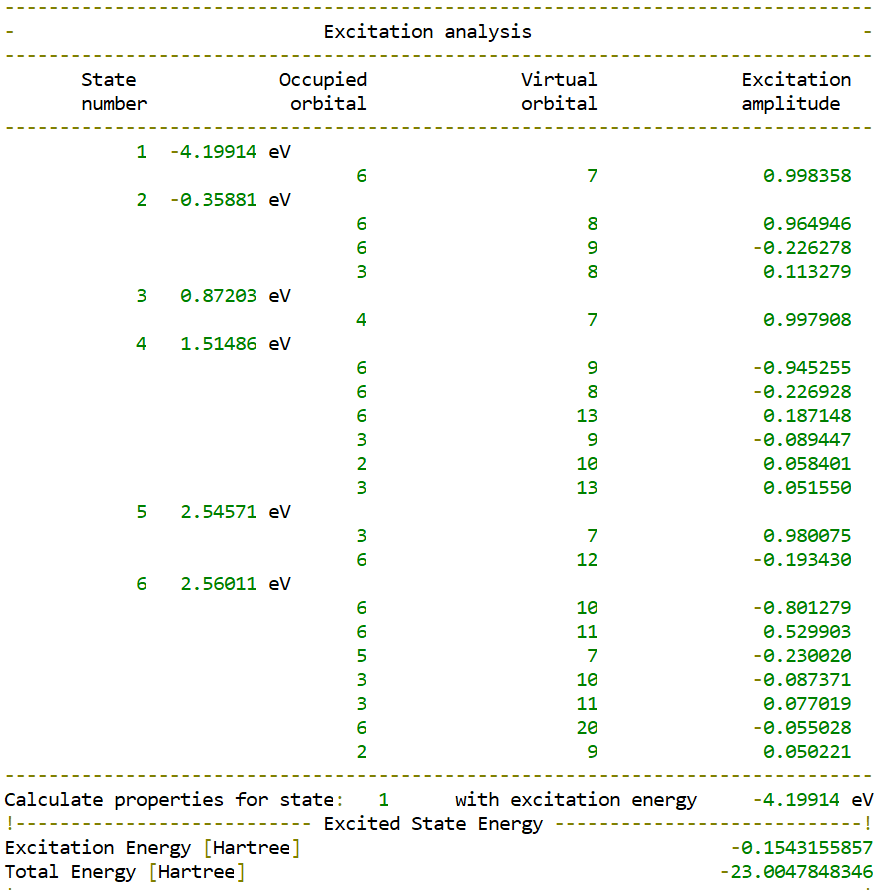 |

#### 2.2.4a PBE0 + TD-DFT (full)
<a name="2.2.4a"></a> [Back to TOC](#TOC)

Excited states calculations with hybrid functionals

In [17]:
if(not os.path.exists("2_2_4a") ):
    os.system("mkdir 2_2_4a")
os.chdir("2_2_4a")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"PBE0", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 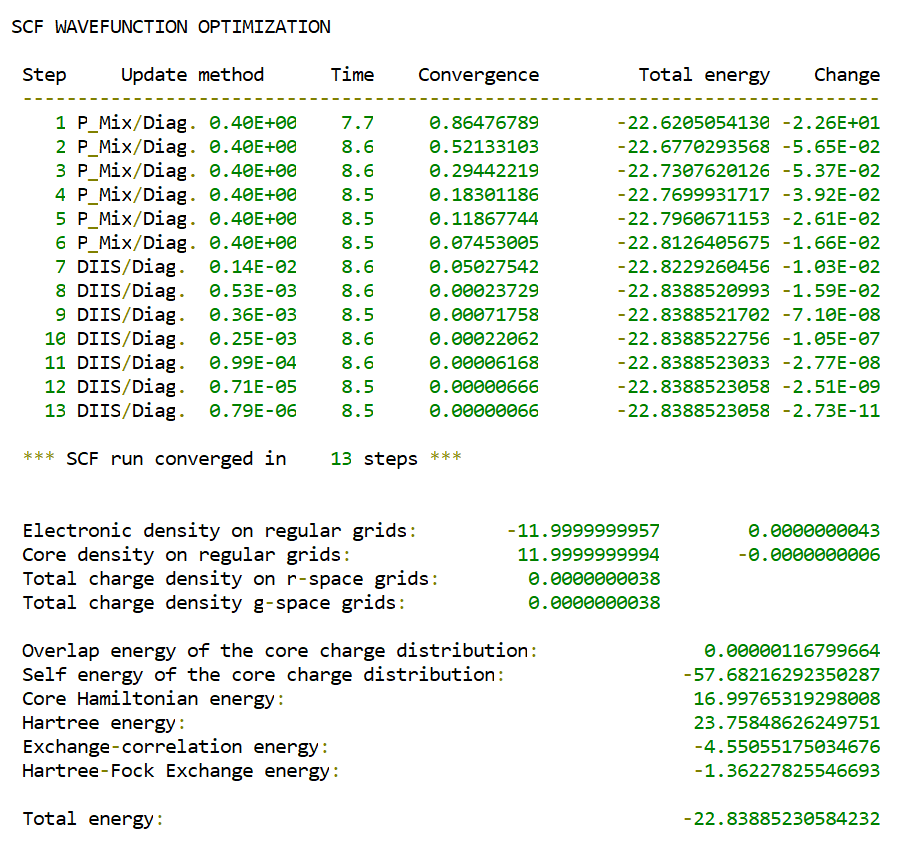 | 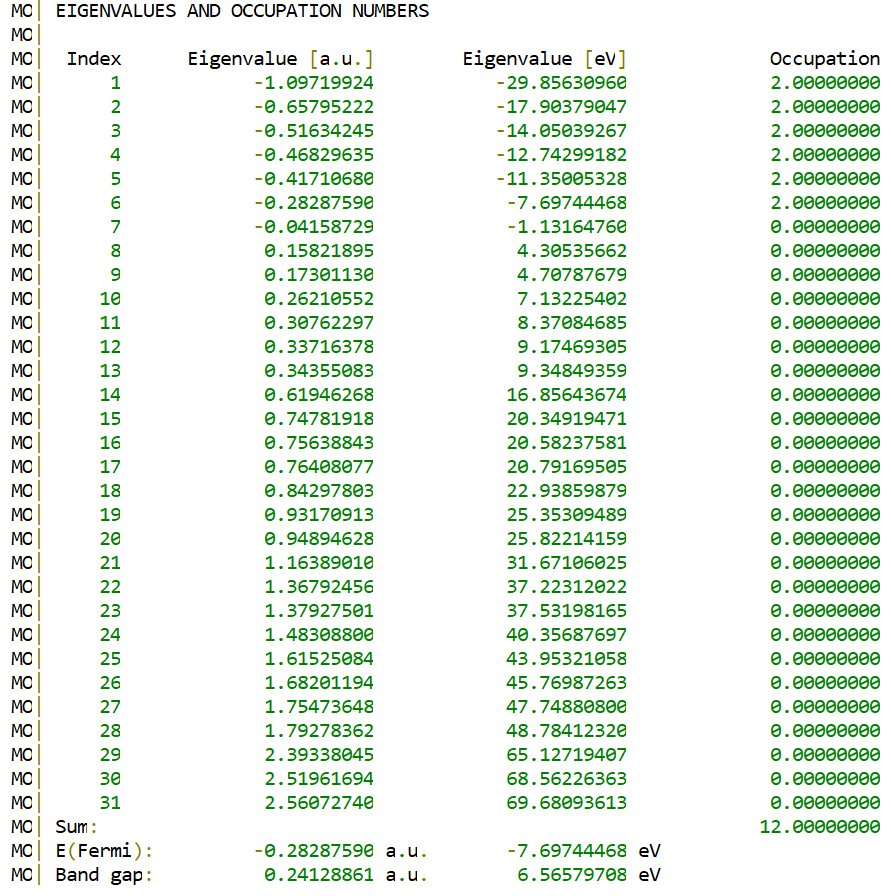 | 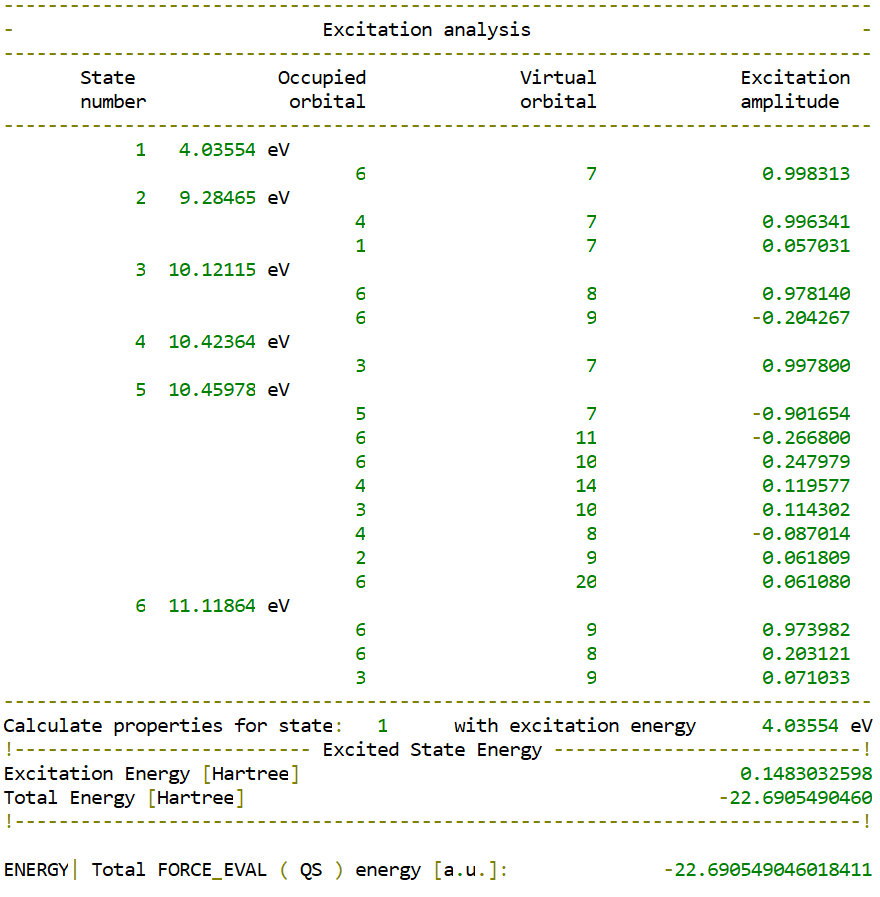 |

#### 2.2.4b B3LYP + TD-DFT (full)
<a name="2.2.4b"></a> [Back to TOC](#TOC)

Excited states calculations with hybrid functionals

In [18]:
if(not os.path.exists("2_2_4b") ):
    os.system("mkdir 2_2_4b")
os.chdir("2_2_4b")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"B3LYP", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 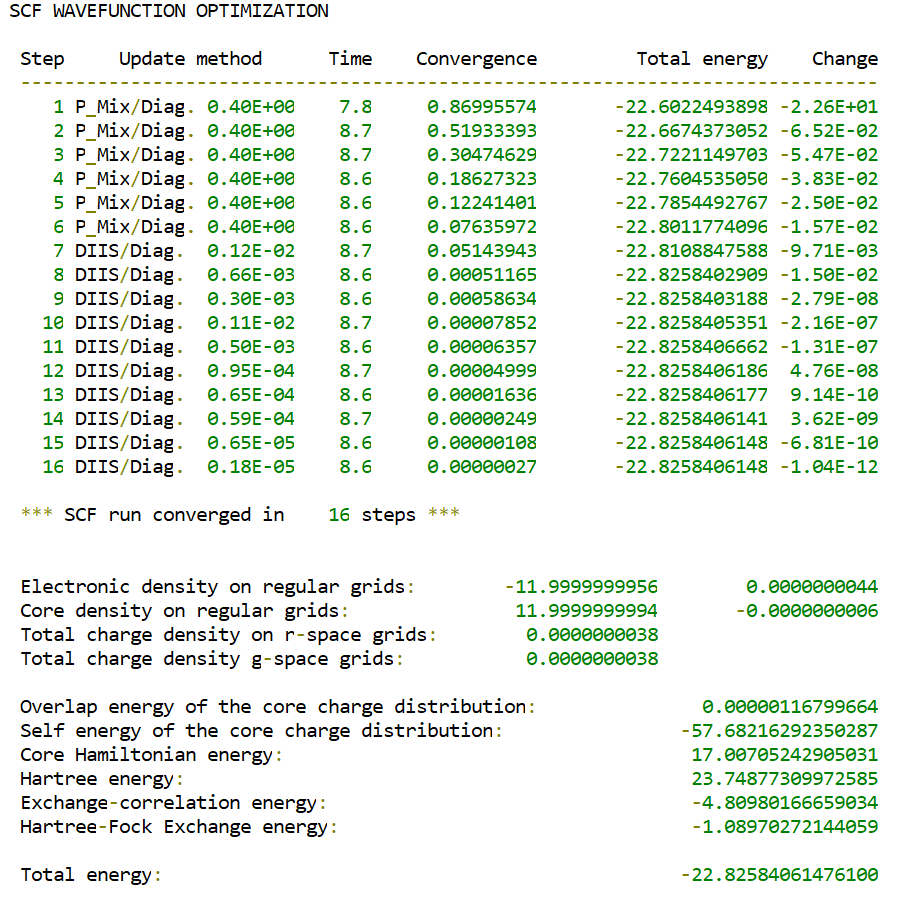 | 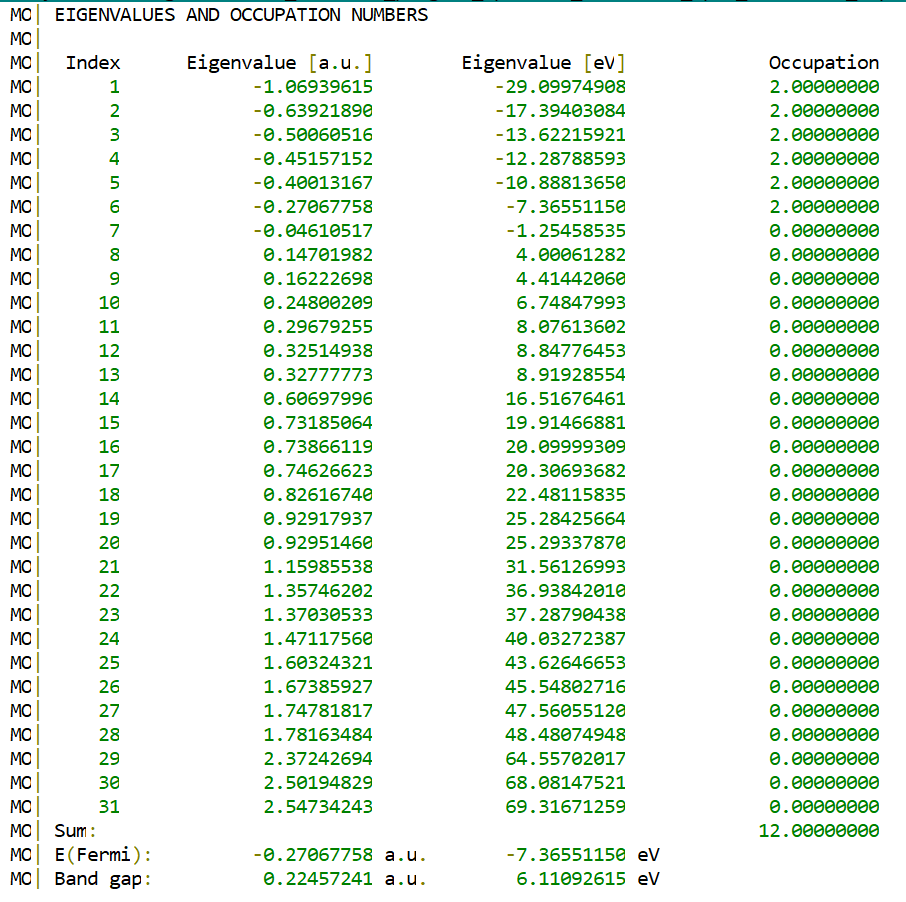 | 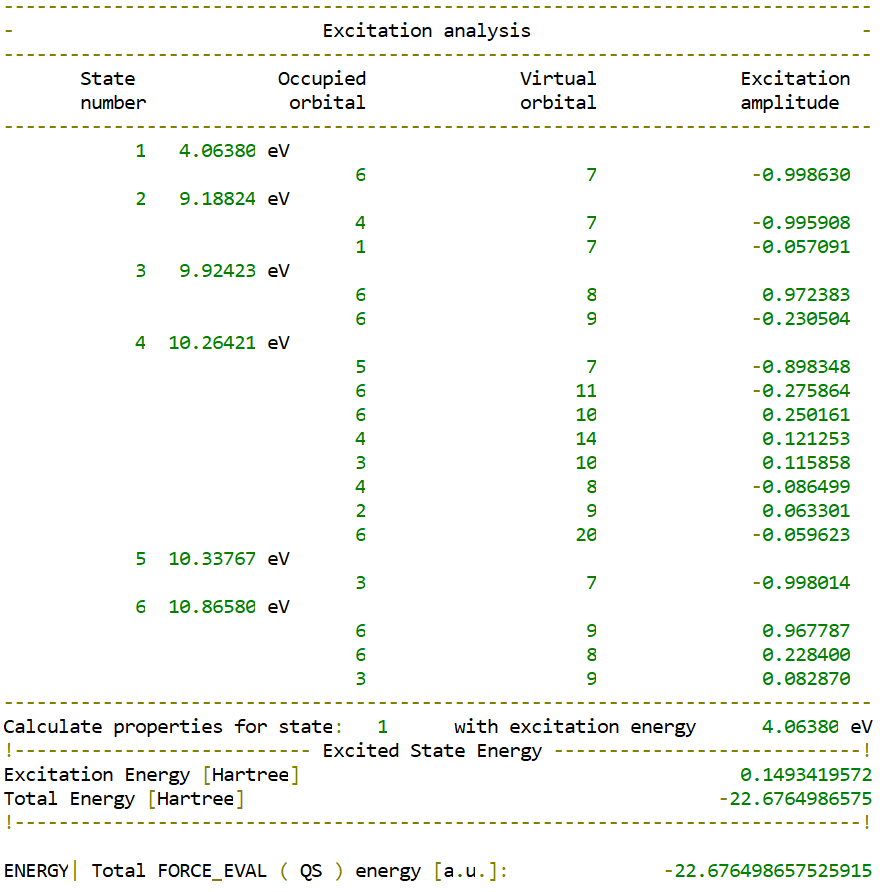 |

#### 2.2.4c CAM-B3LYP + TD-DFT (full)
<a name="2.2.4c"></a> [Back to TOC](#TOC)

Excited states calculations with hybrid functionals

In [19]:
if(not os.path.exists("2_2_4c") ):
    os.system("mkdir 2_2_4c")
os.chdir("2_2_4c")
os.system("cp ../ch2o.xyz .")
os.system("cp ../submit.slm .")
params = dict(default_params)
params.update({"method":"CAM-B3LYP", "solver":"DIAG", "istate":1, "nstates":6, "added_mos":25 })
cp2k_input.generate(params)
os.chdir("../")

[{'element': 'H', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q1', 'fit_basis_set': 'cFIT3'}, {'element': 'C', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q4', 'fit_basis_set': 'cFIT3'}, {'element': 'O', 'basis_set': 'ORB DZVP-GTH', 'potential': 'GTH-PBE-q6', 'fit_basis_set': 'cFIT3'}]


   |     |     |     |
   | --- | --- | --- |
   | 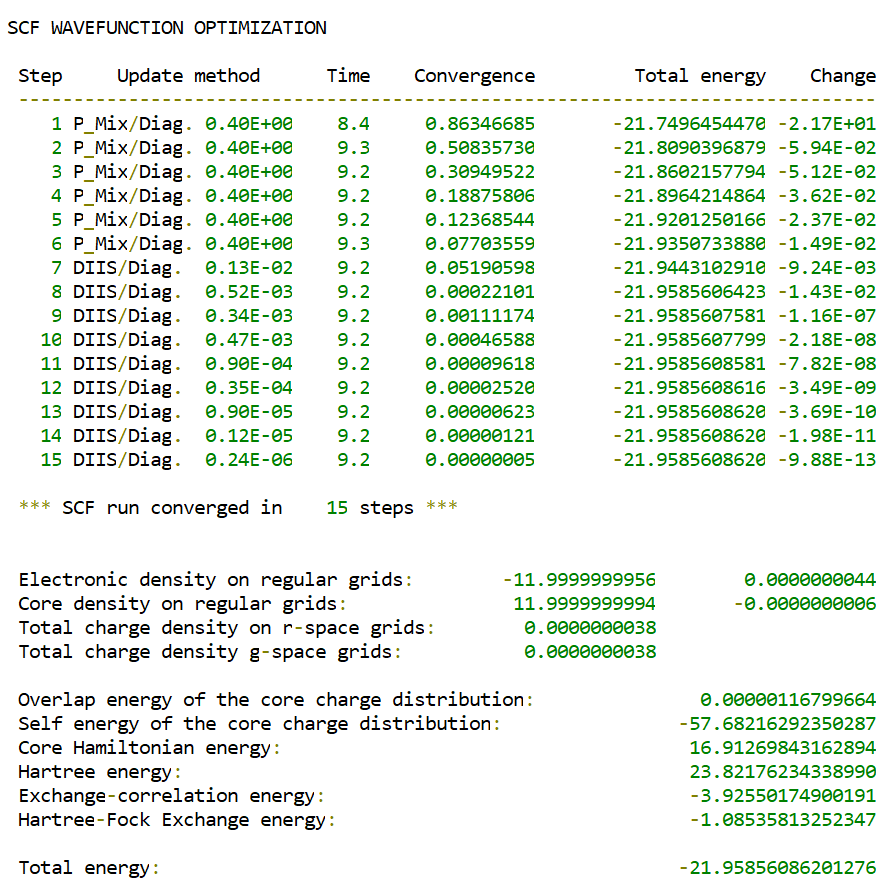 | 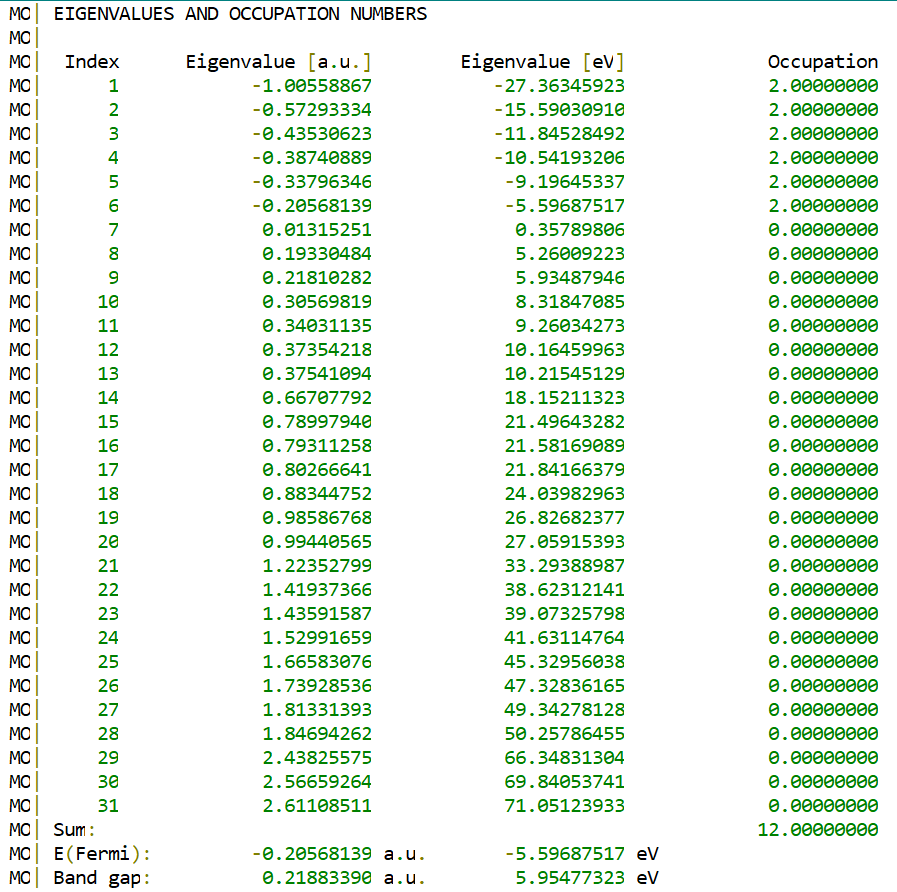 | 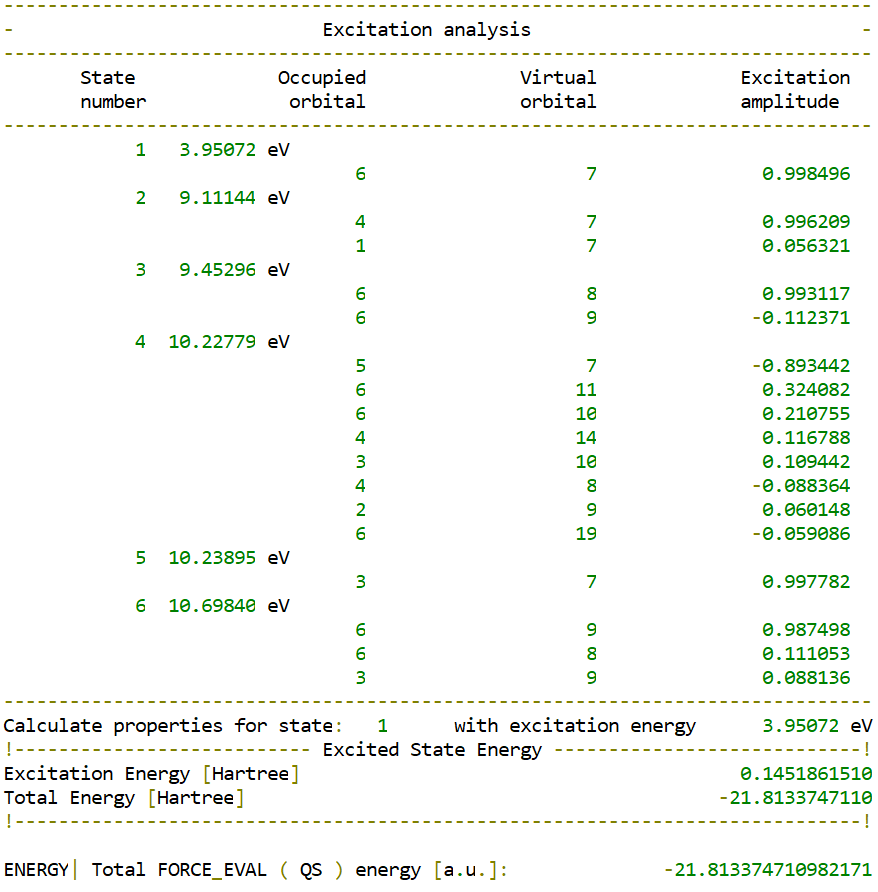 |

## 3. Summary
<a name="3"></a> [Back to TOC](#TOC)

Let's summarize band gaps and first excitation energies with different methods


| Method |  Bandgap, eV | Excitation energy, eV |
| ---    | ---      | ---               |
| xTB(sTDA) | 4.14210955 | -4.37858 |
| PBE | 3.65372339 | 3.92624 |
| PBE(sTDA) | 3.65372339 | -4.19914 |
| PBE0 | 6.56579708 |  4.03554 | 
| B3LYP | 6.11092615 |  4.06380 |
| CAM-B3LYP | 5.95477323 | 3.95072 |


From this table we can conclde:

* Using sTDA really screws the excitation energies (negative energies) - one should use full kernel if possible

* Excitation energies are usually smaller than the band gaps (cause of Coulombic interactions between electron and hole in exciton)

* Hybris functionals increase gap, as expected

* Long-range correction decreases the gap and excitation energies
